In [1]:
%matplotlib inline

In [7]:
import numpy as np
from functools import partial
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from download_net import download_net

In [11]:
data_dir = 'data/'
download_net(data_dir)
model_fn = 'tensorflow_inception_graph.pb'
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

In [12]:
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(os.path.join(data_dir, model_fn), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

In [15]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]
print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

Number of layers 59
Total number of feature channels: 7548


In [103]:

# Helper functions for TF Graph visualization
#pylint: disable=unused-variable
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() #pylint: disable=maybe-no-member
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() #pylint: disable=maybe-no-member
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def

def showarray(a,save=False,save_fname='deepdream.png'):
    plt.figure(figsize=(8,6))
    a = np.uint8(np.clip(a, 0, 1)*255)
    plt.imshow(a)
    plt.show()
    if save:
        plt.imsave(save_fname,a)

def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    img = img0.copy()
    for _ in range(iter_n):
        g, _ = sess.run([t_grad, t_score], {t_input:img})
        # normalizing the gradient, so the same step size should work
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
    showarray(visstd(img))

def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)

def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

In [71]:
def render_deepdream(t_obj, img0=img_noise,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # split the image into a number of octaves
    img = img0
    octaves = []
    for _ in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)

    # generate details octave by octave
    for octave in range(octave_n):
        print('octave {}'.format(octave))
        if octave > 0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for _ in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))

        #this will usually be like 3 or 4 octaves
        #Step 5 output deep dream image via matplotlib
        showarray(img/255)
    return img

In [91]:
def load_image(filename):
    
    if '.png' in filename: 
        img_obj = plt.imread(filename)
    else:
        img_obj = plt.imread(filename)/255
    if len(img_obj.shape) == 3 and img_obj.shape[2] > 3:
        return img_obj[:,:,:3]

In [92]:
import skimage.transform as transform

In [116]:
#Step 3 - Pick a layer to enhance our image
layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 139 # picking some feature channel to visualize

#open image
img0 = load_image('deepdreamtitle.png')
# img0 = transform.rescale(img0, 0.5, )
img0 = np.float32(img0)*255

octave 0


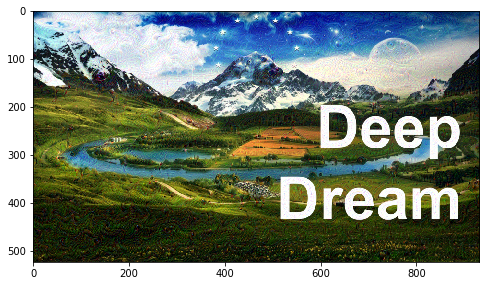

octave 1


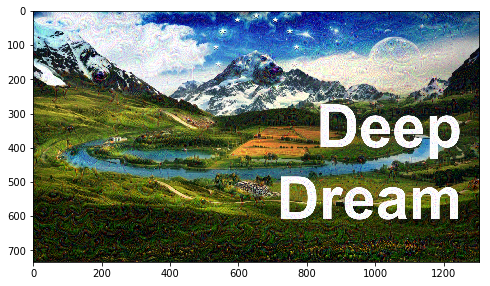

octave 2


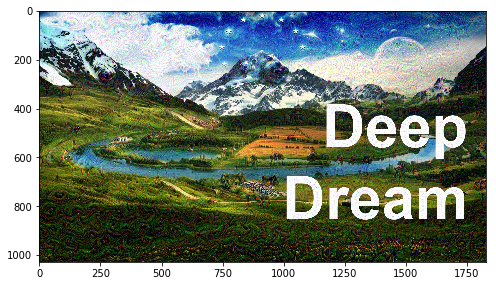

octave 3


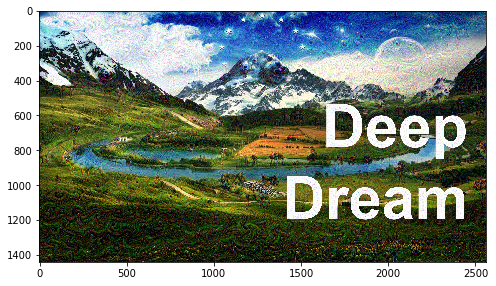

In [117]:
out_img = render_deepdream(tf.square(T('mixed4c')), img0, octave_n=4, iter_n=20)

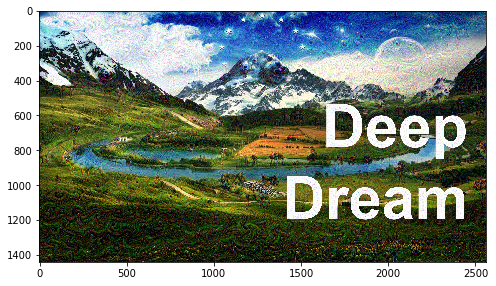

In [118]:
showarray(out_img/255,save=True)